### 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.


First of all, camera calibration is done. For this, the chessboard images in camera_cal folder were read and the findChessboardCorners was used to find the inner corners in the chessboard pattern. Since we know that each image has 9 by 6 corners, we use this information to calcuate the camera callibration matrix mtx and distortion coefficient dst.

In [13]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os 


%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

cv2.destroyAllWindows()

# Get the Camera Matrix and Distortion coefficient
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)


#sample undistorted calibration image
fname = "camera_cal/calibration1.jpg"
write_name = "output_images/calibration1_undistorted.jpg"
img = cv2.imread(fname)
undist = cv2.undistort(img, mtx, dist, None, mtx)
mpimg.imsave(write_name,undist )


###  2. Apply a distortion correction to raw images.

After obtaining the camera matrix and distortion coefficients from the step 1, each of the images in test_images folder is undistorted using cv2 undistort funtion. The resulting undistorted images are put into distortion_corrected sub folder of output_images folder, with the same filename as the original file name. 

One of the original image and its corresponding undistorted image are plotted shown below. Much difference cannot be seen between the original image and its undistorted image in most of the area except on the lower portion of the image containing the hood of the car.

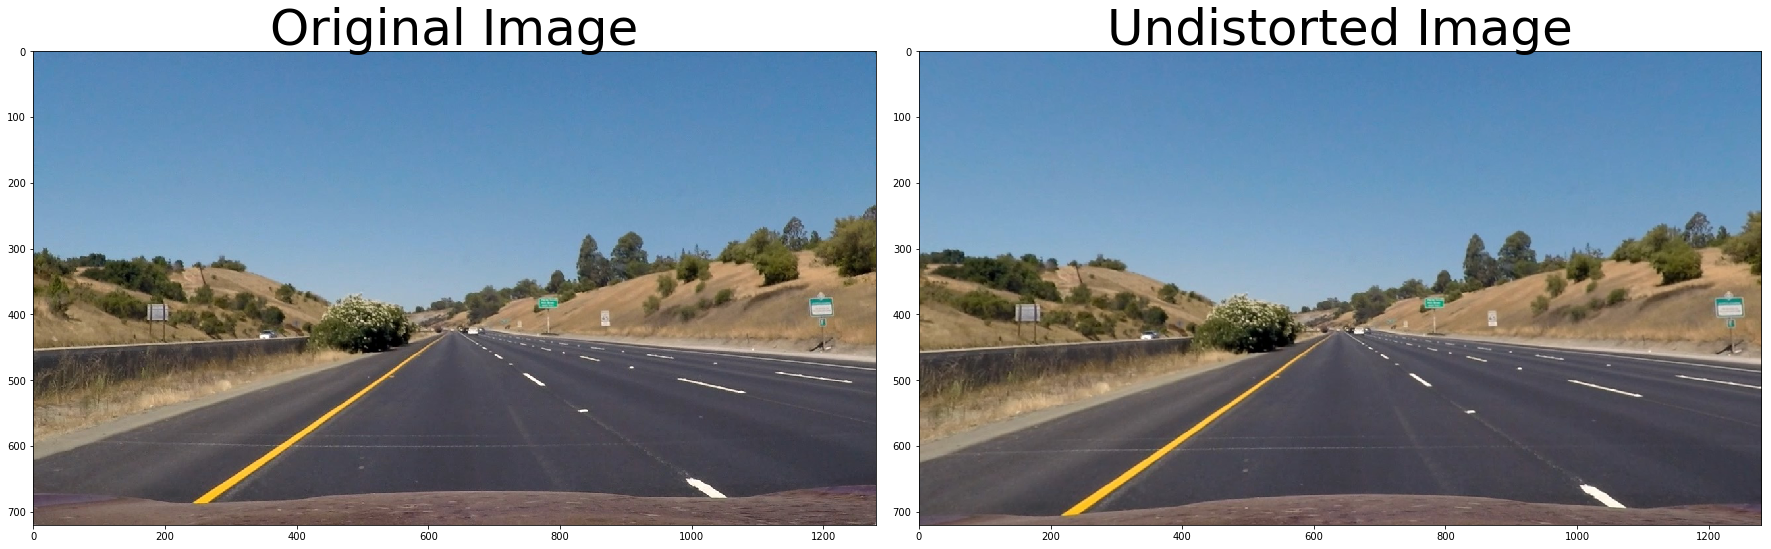

In [2]:

# A function that takes an image performs image distortion correction and returns the undistorted image
def cal_undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist


# get a list of test images and prepare output folder
UNDISTORT_OUTDIR="output_images/distortion_corrected/"
images = glob.glob('test_images/*.jpg')
if os.path.exists(UNDISTORT_OUTDIR) is False:
    os.mkdir(UNDISTORT_OUTDIR)

#undistort each of the images
for idx, fname in enumerate(images):
    # Read in an image
    img = mpimg.imread(fname)
    undistorted = cal_undistort(img)
    write_name = UNDISTORT_OUTDIR+os.path.basename(fname)
    mpimg.imsave(write_name,undistorted )

#Plot the last image for demo
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### 3. Use color transforms, gradients, etc., to create a thresholded binary image.

A thresholded binary image is formed from the undistorted image using the following process:

* a thresholded image is obtained after applying threshold on the sobel x gradient.
    * the undistorted image is converted to gray scale
    * sobel x gradient is obtained from the gray scale image and then normalized to 0 to 255 value using the maximum value of soble x gradient.
    * the normalized sobel x gradient is then compared with the supplied minimum and maximum threshold for sobel x gradient.
* another thresholded image is obtained by applying threshold on the saturation channel.
    * the undistorted image is converted to HLS image and S channel is obtained.
    * threshold for S channel is applied to get the thresholded image
* both of the thresholded images are combined using OR logic.
* only the image portion in the region of interest is obtained. Since we are interested in finding the lanes border of the single lane on which the car is currently driving and we need to remove the noise in unwanted areas, a trapeziod (nearly triangular) type of region of interest infront of the hood of the car is used.
* some noise filter is done by closing and then opening the pixels using 5 by 5 rectangular matrix 


For each of the undistorted images, the thresholded binary image is obtained and saved into thresholded_binary subfolder of output_images folder. A sample undistorted image and its thresholded binary images is also shown below.


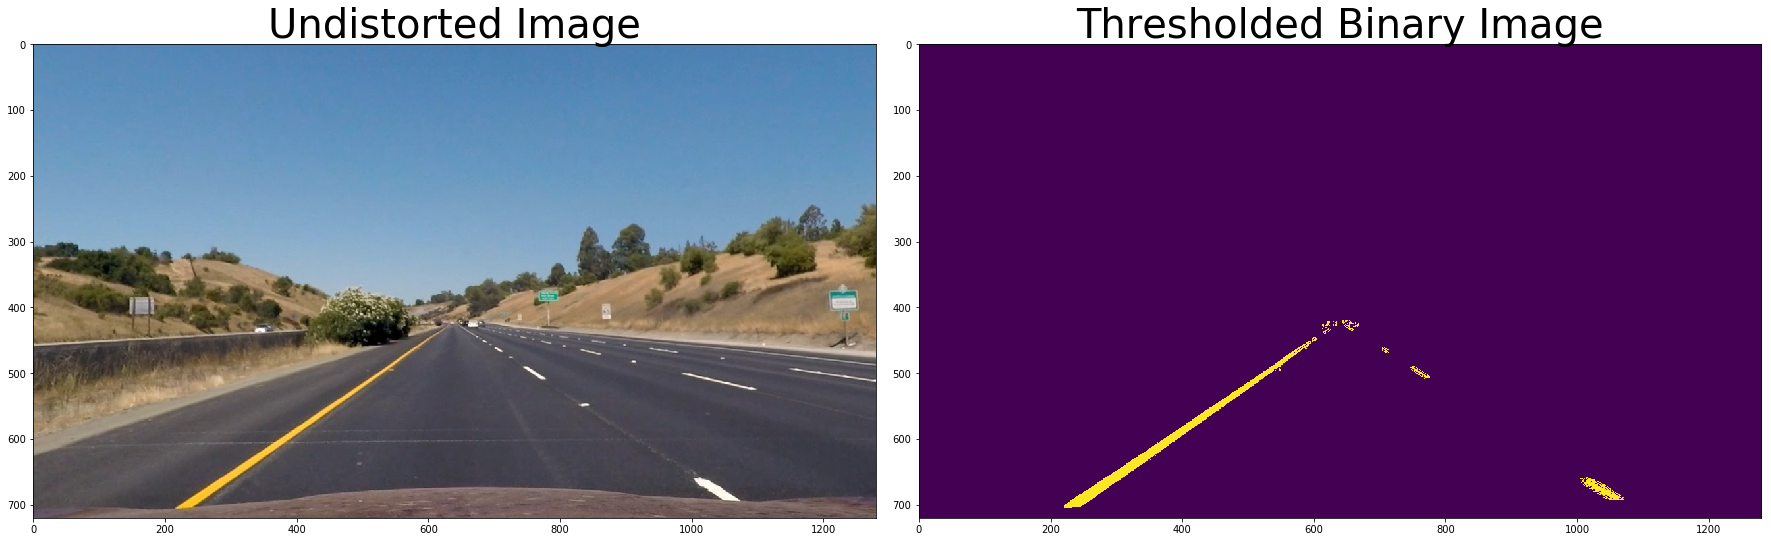

In [3]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def remove_noise(img):
    se1 = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    se2 = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    mask = cv2.morphologyEx(img, cv2.MORPH_CLOSE, se1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, se2)
    mask = mask / 255
    
    return img * mask


# Gets thresholded_binary_image by applying thresholds on S chanel and sobel x gradient. It 
# also applies traingular region of interest mask.
#def get_thresholded_binary_image(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
def get_thresholded_binary_image(img, s_thresh=(170, 255), sx_thresh=(25, 100)):
    img = np.copy(img)

    # Sobel x
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold sobel x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Convert to HLS color space and obtain the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Threshold saturation channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1*255
    
    #allow images in region of interest only
    imshape = img.shape
    #vertices = np.array([[(0 +70,imshape[0]),(imshape[1]/2-20, imshape[0]/2 +30), (imshape[1]/2+20, imshape[0]/2 + 30), (imshape[1]-70,imshape[0])]], dtype=np.int32)     #320
    vertices = np.array([[(0 +70,imshape[0]),(imshape[1]/2-20, imshape[0]/2 +60), (imshape[1]/2+20, imshape[0]/2 + 60), (imshape[1]-70,imshape[0])]], dtype=np.int32)     #320
    masked_edges= region_of_interest(combined_binary, vertices)
    
    masked_edges=remove_noise(masked_edges)

    return masked_edges


# get a list of test images and prepare output folder
THRESHOLD_BINARY_OUTDIR="output_images/thresholded_binary/"
undistorted_images = glob.glob(UNDISTORT_OUTDIR+'*.jpg')
if os.path.exists(THRESHOLD_BINARY_OUTDIR) is False:
    os.mkdir(THRESHOLD_BINARY_OUTDIR)

#undistort and get binary thresholded image 
for idx, fname in enumerate(undistorted_images):
    undistorted = mpimg.imread(fname)
    thresholded_binary_image = get_thresholded_binary_image(undistorted)
    write_name = THRESHOLD_BINARY_OUTDIR+os.path.basename(fname)
    cv2.imwrite(write_name, thresholded_binary_image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undistorted)
ax1.set_title('Undistorted Image', fontsize=40)

ax2.imshow(thresholded_binary_image)
ax2.set_title('Thresholded Binary Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### 4. Apply a perspective transform to rectify binary image ("birds-eye view"). 

In this step, first we find the perspective matrix using a reference image and expected position in top view image and calling method getPerspectiveTransform with those position as source and destination points. Using the perpective matrix, the binary thresholded images are converted to top view and saved into top_view sub folder of  output_images folder.

Here, undistorted image of straight_lines2.jpg is taken as reference. Taking nearest dashed line, dot and the next dashed line as reference for the left side, and comparing to Detail 12 of https://dot.ca.gov/-/media/dot-media/programs/traffic-operations/documents/ca-mutcd/camutcd2014-part3-rev3-a11y.pdf , the length is 60ft. the width of the lane is standard 12 ft. Lets cast this lane section of 60ft by 12 ft to the whole image, such that the length of the lane section is equal to the height of the image.

The reference image straight_lines1.jpg can be found in google map at https://www.google.com/maps/@37.440167,-122.2488739,3a,75y,298.54h,93.8t/data=!3m6!1e1!3m4!1sZ2Tgn_cip1A02fCGc190Fg!2e0!7i16384!8i8192 . There also the ratio of the dashed line, dot and the next dashed line, to the width of the road, is around 5. Hence the assumption made should be nearly accurate.

A sample thresholded binary images and its top view image after the perspective transformation are also plotted below.


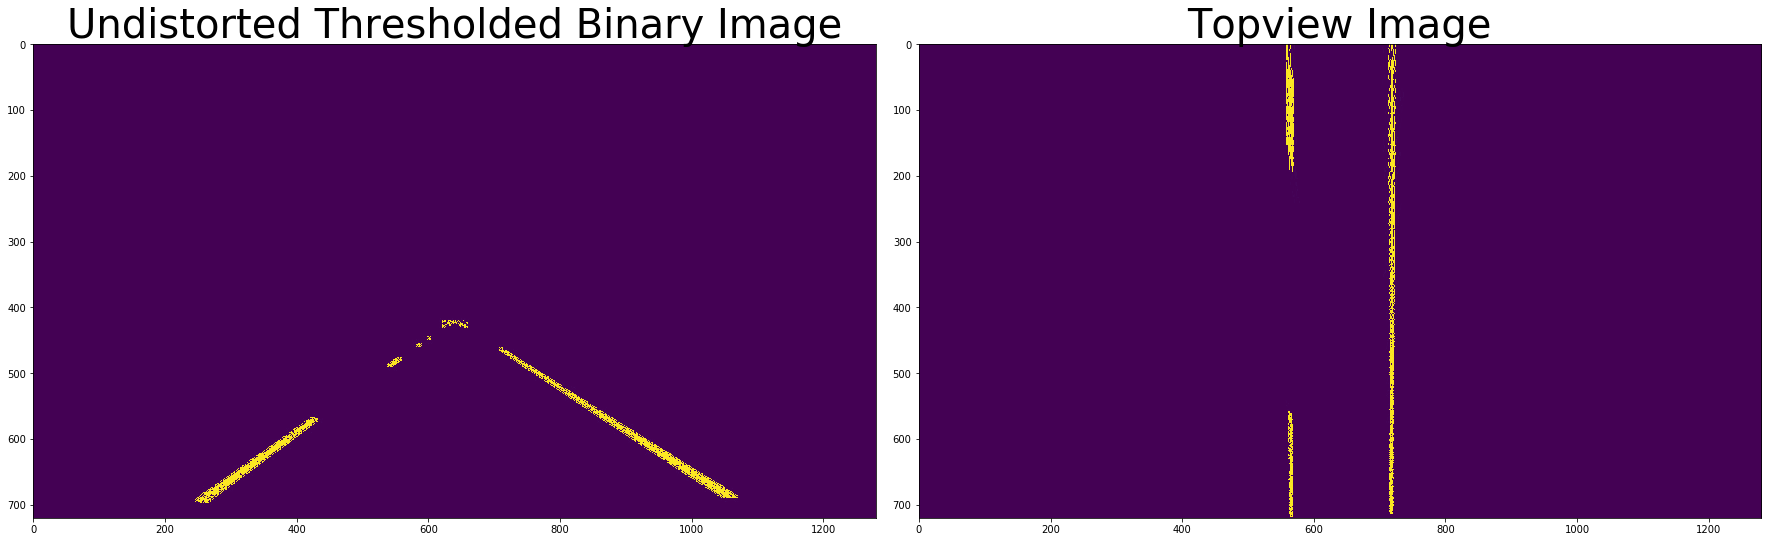

In [4]:
def get_perspective_transform_matrix():
    # get the perspective transform matrix, using straight_lines2.jpg as reference
    
    reference_undistorted_imgname = "output_images/distortion_corrected/straight_lines2.jpg"
    # reference_undistorted_img = mpimg.imread(reference_undistorted_imgname)
    reference_undistorted_img = cv2.imread(reference_undistorted_imgname)

    # print(reference_undistorted_img.shape) #mpimg: (720, 1280, 3)
    img_height =  reference_undistorted_img.shape[0]
    img_width =  reference_undistorted_img.shape[1]
    # print("img_height=%d"%img_height) #mpimg: img_height=720
    # print("img_width=%d"%img_width) #mpimg: img_width=1280

    leftupperpoint  = [565,475]
    leftlowerpoint  = [265,700]
    rightupperpoint = [722,475]
    rightlowerpoint = [1050,700]

    src = np.float32([leftupperpoint, leftlowerpoint, rightupperpoint, rightlowerpoint])
#     dst = np.float32([[604,360], [604,720], [678,360], [678,720]]) # projecting  ref section on lower half image
    dst = np.float32([[568,0], [568,720], [712,0], [712,720]]) # projecting ref section on whole image height

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src )
    
    return M, Minv

def get_perspective_transformed_image(img, persp_tranform_matrix):
    img_size = (img.shape[1], img.shape[0])
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, persp_tranform_matrix, img_size, flags=cv2.INTER_NEAREST)
    return warped

#Get tranform matrix
M, Minv = get_perspective_transform_matrix()

#prepare output folder
TOP_VIEW_OUTDIR="output_images/top_view/"
if os.path.exists(TOP_VIEW_OUTDIR) is False:
    os.mkdir(TOP_VIEW_OUTDIR)

#apply on each undistorted image
#topview_image = get_perspective_transformed_image(reference_undistorted_img, M)
undistorted_binary_images = glob.glob(THRESHOLD_BINARY_OUTDIR+'*.jpg')
for idx, fname in enumerate(undistorted_binary_images):
    undistorted_thresholded_binary = mpimg.imread(fname)
    top_view_image = get_perspective_transformed_image(undistorted_thresholded_binary,M)
    write_name = TOP_VIEW_OUTDIR+os.path.basename(fname)
    cv2.imwrite(write_name, top_view_image)


# Plot a sample image and its top view after perpective transform
fname = THRESHOLD_BINARY_OUTDIR+"straight_lines2.jpg"
undistorted_thresholded_binary = mpimg.imread(fname)
top_view_image = get_perspective_transformed_image(undistorted_thresholded_binary,M)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undistorted_thresholded_binary)
ax1.set_title('Undistorted Thresholded Binary Image', fontsize=40)

ax2.imshow(top_view_image)
ax2.set_title('Topview Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

### 5. Detect lane pixels and fit to find the lane boundary.

In this step, the pixels of the right and left lane boundary are determined on the topview image and then a second order polynomial line is fit on those detected pixel for each side of the lane boundary. 

The detection of the pixels belonging to the left and the right lane boundary are done in the method find_lane_pixels, where a sliding window approach has been taken to detect each of the lane boundary. The histogram of the lower half image in the top view image is taken, in order to determine the initial x position of the left and right lane borders. Then position of the sliding window is changed to the new mean position if the number of detected pixels is greater than minimum required pixels (here 50 pixels).

In the method fit_polynomial, the pixels detected for left and right lane border using method find_lane_pixels, are used to fit a second degree polynomial line for each side lane border, that approximates the position of the detected lane borders. Form the fitted polynomial, the pixels belonging to the lane border are determined and plotted. 
 
 In some case, where there are not enough pixels detected along the length of the lane border, there fitted line for  given y position from 0 to height of the image, had the x positions greater than that of the width of the image, in  such lane lines pixels are not plotted.

A top view image of straight_lines2.jpg and its corresponding detected lane pixels, sliding window and calculated pixels from fitted lines are shown below.


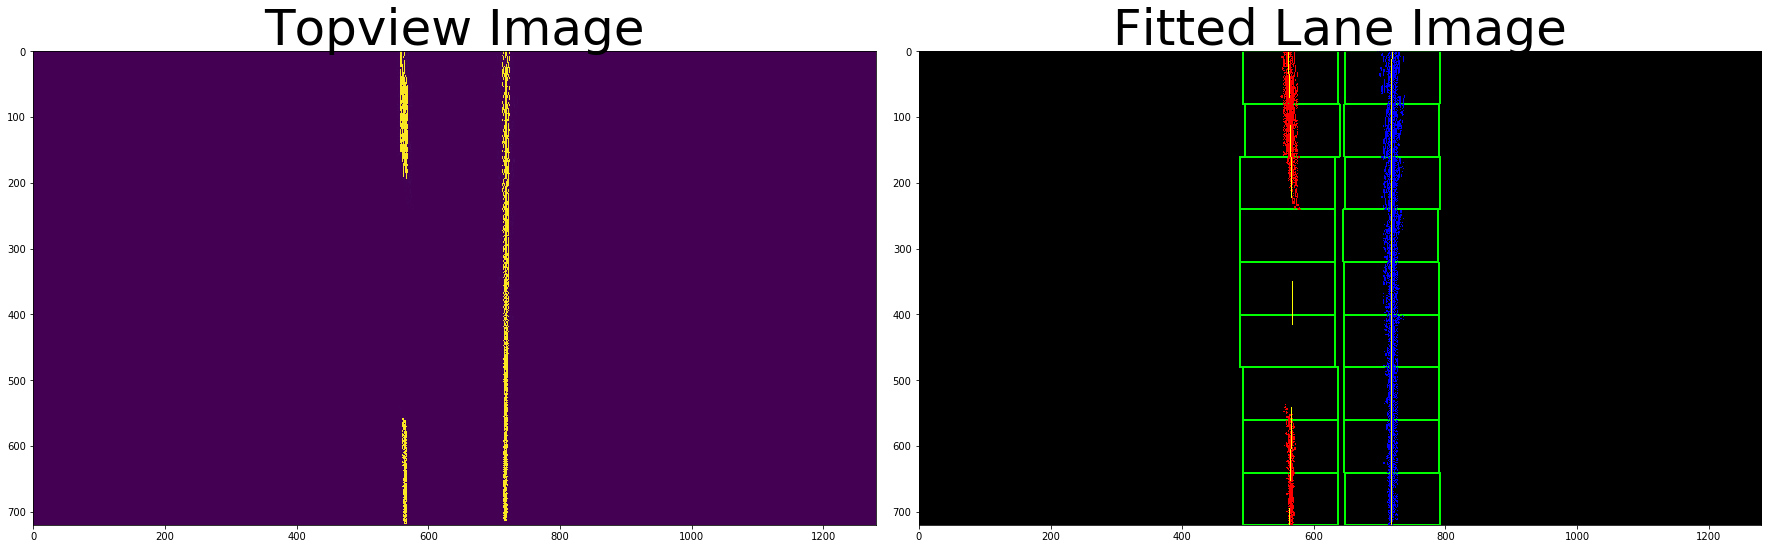

In [5]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
#     margin = 100 #original in udacity
    margin = 72 #TOADJUST: as per the expected width of the lane in the top view.
    
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current-margin  # Update this
        win_xleft_high = leftx_current+margin  # Update this
        win_xright_low = rightx_current-margin  # Update this
        win_xright_high = rightx_current+margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy>=win_y_low) & (nonzeroy<win_y_high) & 
        (nonzerox>=win_xleft_low) & (nonzerox<win_xleft_high) ).nonzero()[0]
        good_right_inds = ((nonzeroy>=win_y_low) & (nonzeroy<win_y_high) & 
        (nonzerox>=win_xright_low) & (nonzerox<win_xright_high)  ).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
#     print("left_fit={0}".format(left_fit))
#     print("right_fit={0}".format(right_fit))

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    out_img[ploty.astype(int),left_fitx.astype(int)] = [255, 255, 0]
    right_fitx_within_image_index = np.where(right_fitx< 1280)
#     print(right_fitx[right_fitx_within_image_index])
    
    #out_img[ploty.astype(int),right_fitx.astype(int)] = [255, 255, 0]
    out_img[right_fitx_within_image_index,right_fitx[right_fitx_within_image_index].astype(int)] = [255, 255, 0]


    return out_img

#prepare output folder
FITTED_LANE_OUTDIR="output_images/fitted_lane/"
if os.path.exists(FITTED_LANE_OUTDIR) is False:
    os.mkdir(FITTED_LANE_OUTDIR)

#apply on each undistorted top view image
binary_thresholded_topview_images = glob.glob(TOP_VIEW_OUTDIR+'*.jpg')
for idx, fname in enumerate(binary_thresholded_topview_images):
    binary_thresholded_topview = mpimg.imread(fname)
    fitted_lane_img = fit_polynomial(binary_thresholded_topview)
    write_name = FITTED_LANE_OUTDIR+os.path.basename(fname)
    cv2.imwrite(write_name, fitted_lane_img)

#Plot sample images    
fname = TOP_VIEW_OUTDIR+"straight_lines2.jpg"
binary_thresholded_topview = mpimg.imread(fname)
fitted_lane_img = fit_polynomial(binary_thresholded_topview)
    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(binary_thresholded_topview)
ax1.set_title('Topview Image', fontsize=50)
ax2.imshow(fitted_lane_img)
ax2.set_title('Fitted Lane Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### 6. Determine the curvature of the lane and vehicle position with respect to center.

In the get_fit_polynomial_parameters method, the lane pixels belonging to the left and right lane borders are found using the method find_lane_pixels. Then using the length per pixels in x and y directions, the second order polynomial is fitted on the pixels points (converted to real distances) for each side of the lane borders.

In method measure_curvature_real, the left and the right fitted line are obtained from method get_fit_polynomial_parameters. The radius of the fitted left and right line are calculated for the bottom position of the image. Similarly the x position of the left and right lane are calculated at the bottom of the image and the average is taken as the center position of the lane. The mid point on the bottom horizontal line of the image is taken as the position of the car. The difference between the car position and the lane center is then taken as the distance of the car from the mid of the lane. While displaying the curvature of the radius of the car, the average of the radius of the curvature of the left and right lane border can be taken. 

The radius of curvature and the position of the vehicle from the center of the lane are printed for each of the images below.

In [6]:
def get_fit_polynomial_parameters(binary_warped_top_view, ym_per_pix, xm_per_pix):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped_top_view)

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    return left_fit_cr, right_fit_cr

def measure_curvature_real(binary_warped_top_view):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    #TOADJUST: as per the distance between the selected points for perspective transform.
    ym_per_pix = 18.29/(binary_warped_top_view.shape[0]) # meters per pixel in y dimension, 60ft length of road accomodated in full of image heigth
    xm_per_pix = 3.67/144 # meters per pixel in x dimension, 12ft road accomodated in 144px

    
    # get the polynomials for the left and right lane borders using the real dist
    left_fit_cr, right_fit_cr = get_fit_polynomial_parameters(binary_warped_top_view, ym_per_pix, xm_per_pix)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = binary_warped_top_view.shape[0] #height of the image.
    
    ##### Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ( (1+(2*left_fit_cr[0]*y_eval*ym_per_pix+left_fit_cr[1])**2)**1.5 ) /np.absolute(2*left_fit_cr[0])  ## Implement the calculation of the left line here
    right_curverad = ( (1+(2*right_fit_cr[0]*y_eval*ym_per_pix+right_fit_cr[1])**2)**1.5 ) /np.absolute(2*right_fit_cr[0])  ## Implement the calculation of the right line here
    
    #calculate the distance from center
    xleft = left_fit_cr[0]*(y_eval*ym_per_pix)**2+left_fit_cr[1]*y_eval*ym_per_pix+left_fit_cr[2]
    xright = right_fit_cr[0]*(y_eval*ym_per_pix)**2+right_fit_cr[1]*y_eval*ym_per_pix+right_fit_cr[2]
    x_lane_mid =(xright+xleft)/2
    x_camera_mid = (binary_warped_top_view.shape[1]/2)*ym_per_pix  #fixed for given setting.
    dist_from_lane_mid = x_camera_mid-x_lane_mid
    
    return left_curverad, right_curverad, dist_from_lane_mid


# Calculate the radius of curvature in meters for both lane lines and also the distance from lane midpoint.
# apply on each undistorted top view image
binary_thresholded_topview_images = glob.glob(TOP_VIEW_OUTDIR+'*.jpg')
for idx, fname in enumerate(binary_thresholded_topview_images):
    binary_thresholded_topview = mpimg.imread(fname)
    print("\n{0}) {1} :".format(idx+1,fname))
    left_curverad, right_curverad, dist_from_lane_mid = measure_curvature_real(binary_thresholded_topview)
    print ("left lane curve radius = {0:.2f}m , right lane curve radius = {1:.2f}m".format(left_curverad, right_curverad))
    print("Vehicle position from the lane middle = {:.2f} m".format(dist_from_lane_mid))




1) output_images/top_view/test6.jpg :
left lane curve radius = 1212.33m , right lane curve radius = 78.41m
Vehicle position from the lane middle = -0.37 m

2) output_images/top_view/test5.jpg :
left lane curve radius = 593.61m , right lane curve radius = 345.29m
Vehicle position from the lane middle = -0.17 m

3) output_images/top_view/test4.jpg :
left lane curve radius = 172.25m , right lane curve radius = 32.62m
Vehicle position from the lane middle = 0.17 m

4) output_images/top_view/test1.jpg :
left lane curve radius = 740.53m , right lane curve radius = 10.23m
Vehicle position from the lane middle = -0.39 m

5) output_images/top_view/test3.jpg :
left lane curve radius = 4510.05m , right lane curve radius = 124.43m
Vehicle position from the lane middle = -0.23 m

6) output_images/top_view/test2.jpg :
left lane curve radius = 526.49m , right lane curve radius = 81.28m
Vehicle position from the lane middle = -0.48 m

7) output_images/top_view/straight_lines2.jpg :
left lane curve ra

### 7. Warp the detected lane boundaries back onto the original image.

In this step, the detected lane boundaries are indicated by overlaying a green area over the detected lane on the original image.

In the method get_fitted_polynomial_line, we get the right and left lane pixels using method find_lane_pixels. Then we fit left and right polynomial line over the detected right and left lane pixels, and then use the fitted polynomial to get a smooth lines representing left and right lane.

Then in the method get_overlaid_image, the pixels of the lines representing left and right lane are used in the cv2 method fillPoly, to draw the lane onto a blank image. Then the blank image (with lane drawn by method fillPoly) is wraped back to original image space using inverse perspective matrix (Minv). Afterwards, the warped image is then combined with the undistorted picture.

A sample image in its top view and its corresponding original image with lane drawn are also shown below.

In [15]:
def get_fitted_polynomial_line(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
        
    return ploty, left_fitx, right_fitx


def get_overlaid_image(binary_thresholded_topview, undist ):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_thresholded_topview).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    #get the lane boundry lines
    ploty, left_fitx, right_fitx = get_fitted_polynomial_line(binary_thresholded_topview)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (binary_thresholded_topview.shape[1], binary_thresholded_topview.shape[0])) 

    # Combine the result with the original image
    lane_overlaid_image = cv2.addWeighted(undist, 1, newwarp, 0.2, 0)
    
    return lane_overlaid_image

    
#prepare output folder
OVERLAY_ORIGINAL_OUTDIR="output_images/overlay_original/"
if os.path.exists(OVERLAY_ORIGINAL_OUTDIR) is False:
    os.mkdir(OVERLAY_ORIGINAL_OUTDIR)


#apply on each undistorted top view image
binary_thresholded_topview_images = glob.glob(TOP_VIEW_OUTDIR+'*.jpg')
for idx, fname in enumerate(binary_thresholded_topview_images):
    #retrive top view image
    binary_thresholded_topview = mpimg.imread(fname)
    # print("filename= {0}".format (os.path.basename(fname) ))

    #retrieve undistorted original image to be overlaid:
    undist = mpimg.imread("%s/%s"%(UNDISTORT_OUTDIR,os.path.basename(fname)))
    
    #get the lane boundry overlaid image
    lane_overlaid_image = get_overlaid_image(binary_thresholded_topview,undist)
    
    #save to a file
    write_name = OVERLAY_ORIGINAL_OUTDIR+os.path.basename(fname)    
    mpimg.imsave(write_name, lane_overlaid_image)

#sample display of the last file.    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(binary_thresholded_topview)
ax1.set_title('Topview Image', fontsize=50)
ax2.imshow(lane_overlaid_image)
ax2.set_title('Overlaid on Original Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


### 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

Here, various results from previous steps are combined to show the lane boudaries and numerical estimation of lane curvate and vehicle position on the original undistorted image. 

* First we retrieve the undistorted image and the top view binary thresholded image, that had been previously calculated. 
* Using the method get_overlaid_image, explained earlier, we get the lane overlaid on the undistorted image of the original image. 
* Using method measure_curvature_real on the binary thresholded topview image, the radius of the curvature and vehicle position is obtained.
* In method draw_data, the image with lane overlaid is annotated with the raduius of curvature and vehicle position. Here cv2 method putText has been used to put the text annotations on the image.


For each of the test images, the corresponding annoated images are calculated as described above and saved into subfolder overlay_original_annotated  of folder output_images. A sample topview image and its annotated result is also shown below.

In [16]:
def draw_data(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curvature radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
#     print("center_dist={0:.3f}, direction={1} ".format(center_dist, direction))
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img



#prepare output folder for the images with lane boundary, lane curvature and vehicle position
OVERLAY_ORIGINAL_ANNOTATED_OUTDIR="output_images/overlay_original_annotated/"
if os.path.exists(OVERLAY_ORIGINAL_ANNOTATED_OUTDIR) is False:
    os.mkdir(OVERLAY_ORIGINAL_ANNOTATED_OUTDIR)


#apply on each undistorted top view image
binary_thresholded_topview_images = glob.glob(TOP_VIEW_OUTDIR+'*.jpg')
for idx, fname in enumerate(binary_thresholded_topview_images):
    #retrive top view image
    binary_thresholded_topview = mpimg.imread(fname)
#     print("filename= {0}".format (os.path.basename(fname) ))

    #retrieve undistorted original image to be overlaid:
    undist = mpimg.imread("%s/%s"%(UNDISTORT_OUTDIR,os.path.basename(fname)))
    
    #get the lane boundry overlaid image
    lane_overlaid_image = get_overlaid_image(binary_thresholded_topview,undist)
    
    #get the curve and position
    left_curverad, right_curverad, dist_from_lane_mid = measure_curvature_real(binary_thresholded_topview)
    lane_overlaid_annotated_image = draw_data(lane_overlaid_image, (left_curverad+right_curverad)/2, dist_from_lane_mid)
    
    #save to a file
    write_name = OVERLAY_ORIGINAL_ANNOTATED_OUTDIR+os.path.basename(fname)    
    mpimg.imsave(write_name, lane_overlaid_annotated_image)

#sample display 
fname = TOP_VIEW_OUTDIR+"straight_lines2.jpg"
binary_thresholded_topview = mpimg.imread(fname)
undist = mpimg.imread("%s/%s"%(UNDISTORT_OUTDIR,os.path.basename(fname)))
lane_overlaid_image = get_overlaid_image(binary_thresholded_topview,undist)
left_curverad, right_curverad, dist_from_lane_mid = measure_curvature_real(binary_thresholded_topview)
lane_overlaid_annotated_image = draw_data(lane_overlaid_image, (left_curverad+right_curverad)/2, dist_from_lane_mid)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(binary_thresholded_topview)
ax1.set_title('Topview Image', fontsize=50)
ax2.imshow(lane_overlaid_annotated_image)
ax2.set_title('Annotated Original Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### 9. Process on video

In order to process the video, a method process_pipeline has been created combining the previous steps explained earlier. The following steps are performed on the original image passed to the method:
* get the undistorted image first from original image using cal_undistort method.
* get undistorted thresholded image after thresholding the undistorted image using method get_thresholded_binary_image.
* get the top view of the binary threholded image from the undistorted thresholded image using method get_perspective_transformed_image .
* get the lane boundary overlaid image from the binary threholded image using method get_overlaid_image.
* get the curve and position from the binary thresholded image using measure_curvature_real method.
* annotate the radius and distance on the lane boundary overlaid image using draw_data method.
* This annotated image is returned by the method process_pipeline.


This  process_pipeline is passed to the fl_image method as image function in order to process the project video file project_video.mp4 . The output video is saved as project_video_output.mp4 file.

In [9]:
def process_pipeline(image):
    
    #get the undistorted image first
    undistorted = cal_undistort(image)
    
    #get undistorted thresholded image after thresholding the undistorted image
    undistorted_thresholded_binary = get_thresholded_binary_image(undistorted)
    
    #get the top view of the binary threholded image
    binary_thresholded_topview = get_perspective_transformed_image(undistorted_thresholded_binary,M)
    
    #get the lane boundry overlaid image
    lane_overlaid_image = get_overlaid_image(binary_thresholded_topview,undistorted)
    
    #get the curve and position
    left_curverad, right_curverad, dist_from_lane_mid = measure_curvature_real(binary_thresholded_topview)
    
    #annotate the radius and distance on the overlaid image
    lane_overlaid_annotated_image = draw_data(lane_overlaid_image, (left_curverad+right_curverad)/2, dist_from_lane_mid)
    
    return lane_overlaid_annotated_image

    

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video project_video_output.mp4.
Moviepy - Writing video project_video_output.mp4



Moviepy - Done !
Moviepy - video ready project_video_output.mp4
CPU times: user 2min 42s, sys: 23.9 s, total: 3min 6s
Wall time: 3min 1s
